In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [33]:
data =yf.download("SPY", start="2017-02-17", end="2022-02-17" )
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-17,233.949997,235.089996,233.929993,235.089996,209.403427,77204100
2017-02-21,235.520004,236.690002,235.509995,236.490005,210.650467,88946100
2017-02-22,236.020004,236.539993,235.830002,236.279999,210.463440,62115200
2017-02-23,236.880005,236.899994,235.559998,236.440002,210.605927,74615900
2017-02-24,235.460007,236.789993,235.410004,236.740005,210.873199,82381600


## Create prediction features from diff


In [34]:
data['Open-Close'] = data.Open - data.Close
data['High-Low'] = data.High - data.Low

In [74]:
def stochastic_oscillator(data, window_size):
    high_max = data['High'].rolling(window=window_size).max()
    low_min = data['Low'].rolling(window=window_size).min()
    k = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    return k

In [76]:
data['stc'] = stochastic_oscillator(data, 7)
data['stc']

/tmp/ipykernel_22389/35297353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stc'] = stochastic_oscillator(data, 7)


Date
2017-05-26          NaN
2017-05-30          NaN
2017-05-31          NaN
2017-06-01          NaN
2017-06-02          NaN
                ...    
2022-02-10    38.418597
2022-02-11     8.025284
2022-02-14    16.326492
2022-02-15    47.737381
2022-02-16    49.955659
Name: stc, Length: 1191, dtype: float64

In [78]:
data = data.dropna()

In [79]:
X = data[['Open-Close', 'High-Low', 'stc']]
X.head()

,Open-Close,High-Low,stc
Date,,,
2017-06-06,0.129990,0.860001,69.272309
2017-06-07,-0.059998,1.089996,81.401585
2017-06-08,-0.009995,1.160004,84.635949
2017-06-09,0.679993,3.059998,52.522458
2017-06-12,-0.229996,1.039993,46.078588


## Define a class label for prediction  -> Buy or not
Given the features condition define if we should Buy or not. We will store 1 for a buy signal and 0 for a no position in y


In [82]:
# Target variables
y = np.where(data['stc'] < 20, 1, np.where(data['stc'] > 80, -1, 0))

# Print y
y

array([ 0, -1, -1, ...,  1,  0,  0])

## Split data 

In [83]:
# Define the split percentage
split_percentage = 0.8
split = int(split_percentage*len(data))

# Train data set
X_train = X[:split]
y_train = y[:split]

# Test data set
X_test = X[split:]
y_test = y[split:]

## SVC model

In [84]:
cls = SVC().fit(X_train, y_train)

In [85]:
y_predict = cls.predict(X_test)

In [86]:
# train and test accuracy
accuracy_test = accuracy_score(y_test, y_predict)

print('Accuracy:{: .2f}%'.format(accuracy_test*100))

Accuracy: 100.00%


## Test Cumulative returns

/tmp/ipykernel_22389/672259180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted_Signal'] = cls.predict(X)
/tmp/ipykernel_22389/672259180.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Returns'] = data.Close.pct_change()
/tmp/ipykernel_22389/672259180.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

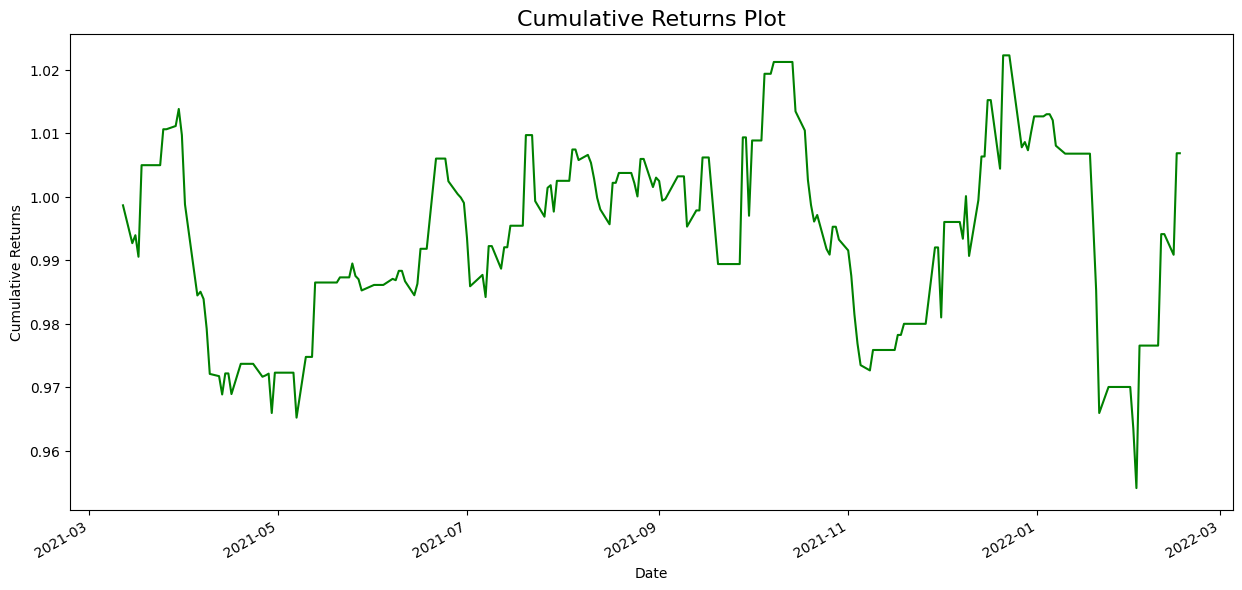

In [87]:
# Predicted Signal
data['Predicted_Signal'] = cls.predict(X)

# Calculate daily returns
data['Returns'] = data.Close.pct_change()

# Calculate strategy returns
data['Strategy_Returns'] = data.Returns * data.Predicted_Signal.shift(1)

# Calculate geometric returns
data['cumulative_returns'] = (data.Strategy_Returns.iloc[split:]+1).cumprod()

# Set the title and axis labels
plt.title("Cumulative Returns Plot", fontsize=16)
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")

# Plot geometric returns
data['cumulative_returns'].plot(figsize=(15, 7),color='g')

plt.show()